In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os

In [2]:
# Only editable variable:
PATH = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams"

# Set the directory:
os.chdir(PATH)

### Metrics

In [1241]:
def obj_fun_nsee(observations, simulation, expo = 0.5):
    metric = np.nansum(np.power(np.power(simulation, expo)  - np.power(observations,expo), 2)) / np.nansum(np.power(np.power(observations, expo)  - np.nanmean(np.power(observations, expo)), 2))
    return float(metric)




def obj_fun_kge(observations, simulation):
    obs_mean = np.nanmean(observations)
    sim_mean = np.nanmean(simulation)
    
    # Pearson correlation coefficient
    r = np.corrcoef(observations, simulation)[0, 1]
    
    # Variability ratio (alpha)
    alpha = np.nanstd(simulation) / np.nanstd(observations)
    
    # Bias ratio (beta)
    beta = sim_mean / obs_mean
    
    # KGE formula
    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return float(kge)





def obj_fun_nsee(observations, simulation, expo=1.0):
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)


    mask = ~np.isnan(observations) & ~np.isnan(simulation)
    obs = observations[mask]
    sim = simulation[mask]
    
    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    return float(metric)


def obj_fun_kge(observations, simulation):
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    mask = ~np.isnan(observations) & ~np.isnan(simulation)
    obs = observations[mask]
    sim = simulation[mask]
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)
    
    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean
    
    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012 version
    return float(kge)


In [1242]:
network_estreams = pd.read_csv('streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,['CH000197'],1,16,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,['CH000221'],1,1,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,['CH000215'],1,2,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,['CH000227'],1,1,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,['CH000214'],1,3,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,['UAGR0019']


In [3]:
# Daily streamflow time-series
timeseries_estreams = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams\streamflow\estreams_timeseries_streamflow.csv", index_col=0)
timeseries_estreams.index = pd.to_datetime(timeseries_estreams.index)
timeseries_estreams.index.name = "dates"
timeseries_estreams

,AT000001,AT000002,AT000003,AT000004,AT000005,AT000006,AT000007,AT000008,AT000009,AT000010,...,UAGR0012,UAGR0013,UAGR0014,UAGR0015,UAGR0016,UAGR0017,UAGR0018,UAGR0019,UAGR0020,UAGR0021
dates,,,,,,,,,,,,,,,,,,,,,
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='dates'>

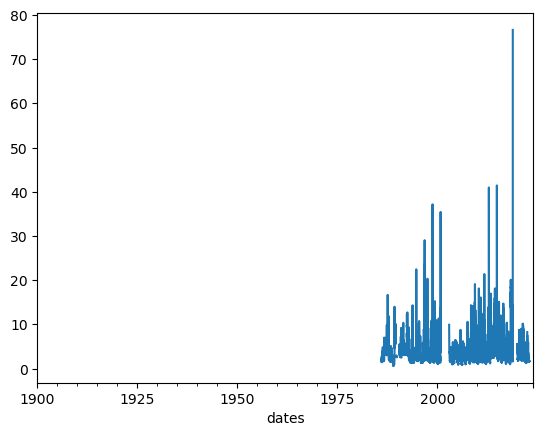

In [1243]:
#basin_id = "FR000702"
#basin_id = "PL000700"
basin_id = "FR000154"
basin_id = "CH000001"
basin_id = "FR003237" # Epinal
#basin_id = "DERP2004" # GemuendOur
#basin_id = "DERP2007" # Pruemzurlay
basin_id = "DERP2023"
basin_id = "LU000011"
basin_id = "LU000001"
basin_id = "LU000007" #Ettelbruck
basin_id = "LU000015" #Michelau
basin_id = "FR003252" 

#basin_id = "PT000102" 

#basin_id = "ITVE0429" 





timeseries_estreams.loc[:, basin_id].plot()

In [1244]:
network_estreams.loc[basin_id, :]

gauge_id                                 62VE
gauge_name             Padola a Santo Stefano
gauge_country                              IT
gauge_provider                         IT_VEN
river                                  Padola
lon_snap                            12.547678
lat_snap                            46.559269
lon                                 12.547678
lat                                 46.559269
elevation                              905.09
area_official                           134.0
area_estreams                         131.348
area_flag                                   0
area_rel                             1.979104
start_date                1986-01-01 00:00:00
end_date                  2022-12-31 00:00:00
num_years                                  36
num_months                                386
num_days                                11422
num_continuous_days                      1777
num_days_gaps                          2092.0
num_days_reliable                 

In [1245]:

data = pd.read_csv("meteorology/estreams_meteorology_"+basin_id+".csv", index_col=0)

data

,p_mean,t_mean,t_min,t_max,sp_mean,rh_mean,ws_mean,swr_mean,pet_mean
date,,,,,,,,,
1950-01-01,0.00,-3.80,-5.39,-4.56,1033.05,66.70,NaN,64.86,0.19
1950-01-02,0.31,-7.33,-12.78,-0.14,1026.26,62.54,NaN,64.72,0.33
1950-01-03,3.19,-2.89,-7.40,2.03,1007.13,82.33,NaN,30.14,0.41
1950-01-04,7.56,-4.96,-6.23,-3.97,1005.20,89.73,NaN,25.57,0.18
1950-01-05,5.59,-3.87,-7.50,-1.03,1009.59,87.20,NaN,45.57,0.32
...,...,...,...,...,...,...,...,...,...
2023-06-26,0.00,15.13,8.44,22.02,1016.06,63.20,1.17,307.14,4.73
2023-06-27,2.70,15.00,9.14,19.92,1015.09,90.56,2.25,119.72,4.20
2023-06-28,0.00,12.55,9.41,16.28,1017.01,87.80,1.82,187.00,3.09


In [1246]:
area = network_estreams.loc[basin_id, "area_estreams"]
area

131.348

In [1247]:
data["Q"] = np.nan
data["Q"] = timeseries_estreams.loc[:, basin_id]
data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)
data

,p_mean,t_mean,t_min,t_max,sp_mean,rh_mean,ws_mean,swr_mean,pet_mean,Q
date,,,,,,,,,,
1950-01-01,0.00,-3.80,-5.39,-4.56,1033.05,66.70,NaN,64.86,0.19,NaN
1950-01-02,0.31,-7.33,-12.78,-0.14,1026.26,62.54,NaN,64.72,0.33,NaN
1950-01-03,3.19,-2.89,-7.40,2.03,1007.13,82.33,NaN,30.14,0.41,NaN
1950-01-04,7.56,-4.96,-6.23,-3.97,1005.20,89.73,NaN,25.57,0.18,NaN
1950-01-05,5.59,-3.87,-7.50,-1.03,1009.59,87.20,NaN,45.57,0.32,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,0.00,15.13,8.44,22.02,1016.06,63.20,1.17,307.14,4.73,NaN
2023-06-27,2.70,15.00,9.14,19.92,1015.09,90.56,2.25,119.72,4.20,NaN
2023-06-28,0.00,12.55,9.41,16.28,1017.01,87.80,1.82,187.00,3.09,NaN


In [1248]:
#data = data.loc["1988":"2001", :]
data = data.loc["2002":"2015"]

data

,p_mean,t_mean,t_min,t_max,sp_mean,rh_mean,ws_mean,swr_mean,pet_mean,Q
date,,,,,,,,,,
2002-01-01,0.00,-10.01,-14.59,-4.57,1040.94,55.70,1.27,53.57,0.22,NaN
2002-01-02,0.00,-4.42,-12.62,2.15,1031.81,34.22,2.32,59.14,0.46,NaN
2002-01-03,0.00,-6.89,-12.34,-2.49,1033.97,54.14,0.57,45.57,0.31,NaN
2002-01-04,0.00,-9.26,-14.92,-4.51,1041.10,48.32,1.20,59.72,0.25,NaN
2002-01-05,0.00,-4.20,-10.63,0.11,1040.26,46.25,1.04,51.00,0.41,NaN
...,...,...,...,...,...,...,...,...,...,...
2014-12-27,3.21,-7.43,-9.99,-5.31,1014.07,81.06,0.75,21.43,0.20,2.058897
2014-12-28,1.61,-6.44,-8.44,-4.27,1010.03,75.10,0.88,30.00,0.20,2.104943
2014-12-29,0.11,-9.40,-13.71,-5.08,1027.90,59.77,2.02,51.43,0.22,2.026007


<Axes: xlabel='date'>

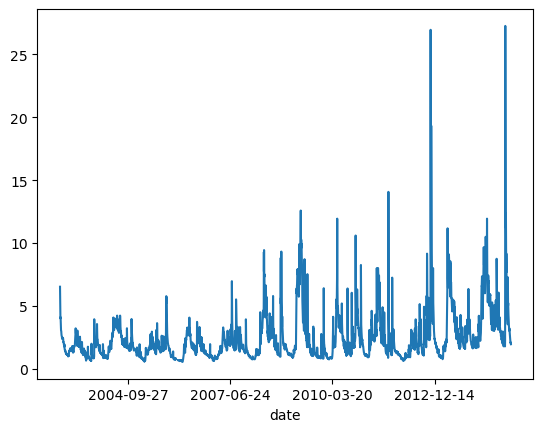

In [1249]:
data.Q.plot()

<Axes: xlabel='dates'>

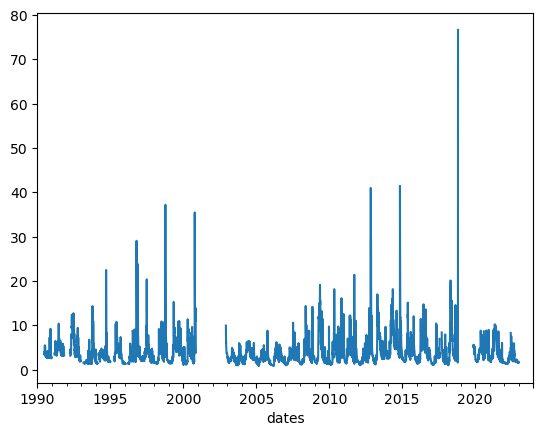

In [1250]:
timeseries_estreams.loc["1990":, basin_id].plot()

In [1251]:
data.Q.isnull().values.any()

True

In [1252]:
data.p_mean.isnull().values.any()

False

In [1253]:
data['pet_mean'] = data['pet_mean'].interpolate()
data.pet_mean.isnull().values.any()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_5812\2048656765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pet_mean'] = data['pet_mean'].interpolate()


False

<Axes: xlabel='date'>

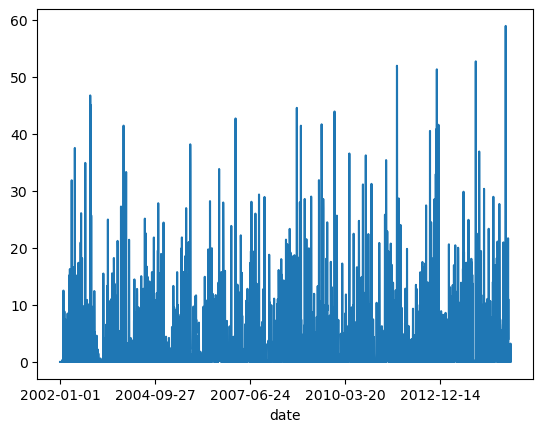

In [1254]:
data.loc[:, "p_mean"].plot()

<Axes: xlabel='date'>

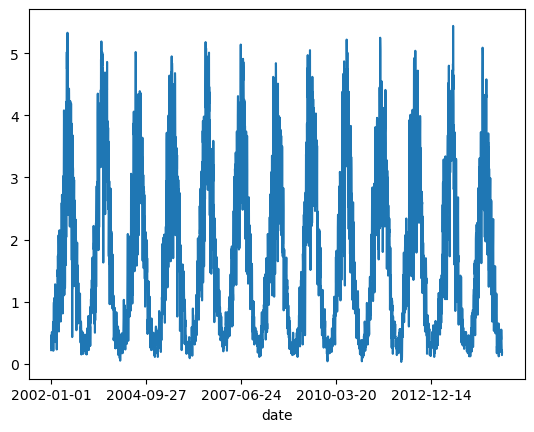

In [1255]:
data.loc[:, "pet_mean"].plot()

<Axes: xlabel='date'>

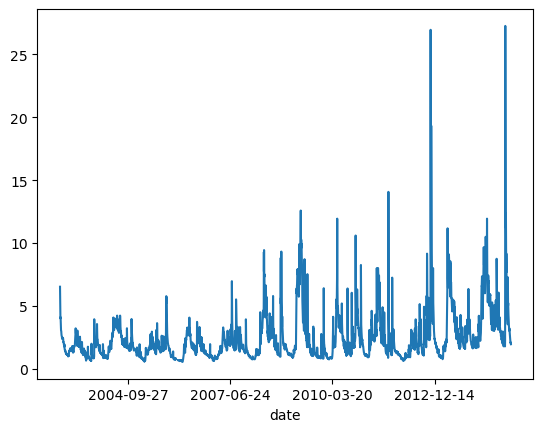

In [1256]:
data.loc[:, "Q"].plot()

In [1257]:
Q_obs = data.loc[:, "Q"].values
Q_obs

array([       nan,        nan,        nan, ..., 2.02600725, 1.96022779,
       1.95364985])

In [1258]:
P = data.loc[:, "p_mean"].values
P

array([0.  , 0.  , 0.  , ..., 0.11, 2.29, 0.1 ])

In [1259]:
E = data.loc[:, "pet_mean"].values
E

array([0.22, 0.46, 0.31, ..., 0.22, 0.14, 0.18])

#### Calibration:

In [1260]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter2 = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.6},
    id='lowersplitter'
)

unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)


lower_splitter = Splitter(
    direction=[
        [0],
        [1]
    ],
    weight=[
        [1.0],   # Portion to slow reservoir
        [1.0]    # Portion to fast reservoir
    ],
    id='lower-splitter'
)


fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

hyd_mod = Unit(
    layers=[
        [unsaturated],
        [lower_splitter2],
        #[lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

hyd_mod

Module: superflexPy
Unit: M4
Layers:
	[['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: unsaturated
Parameters:
	M4_unsaturated_Smax : 50.0
	M4_unsaturated_Ce : 1.0
	M4_unsaturated_m : 0.01
	M4_unsaturated_beta : 2.0
States:
	M4_unsaturated_S0 : 10.0

********************
Module: superflexPy
Element: lowersplitter
Parameters:
	M4_lowersplitter_split-par : 0.6

********************
Module: superflexPy
Element: slow
Parameters:
	M4_slow_k : 0.0001
	M4_slow_alpha : 1.0
States:
	M4_slow_S0 : 0.0

********************
Module: superflexPy
Element: lag-fun
Parameters:
	M4_lag-fun_lag-time : 4.0
States:
	M4_lag-fun_lag : None

********************
Module: superflexPy
Element: lower-transparent

********************
Module: superflexPy
Element: fast
Parameters:
	M4_fast_k : 0.01
	M4_fast_alpha : 2.0
States:
	M4_fast_S0 : 0.0

********************
Module: superflexPy
Element: lower-juncti

In [1261]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        #obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [1262]:
print(hyd_mod)

Module: superflexPy
Unit: M4
Layers:
	[['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: unsaturated
Parameters:
	M4_unsaturated_Smax : 50.0
	M4_unsaturated_Ce : 1.0
	M4_unsaturated_m : 0.01
	M4_unsaturated_beta : 2.0
States:
	M4_unsaturated_S0 : 10.0

********************
Module: superflexPy
Element: lowersplitter
Parameters:
	M4_lowersplitter_split-par : 0.6

********************
Module: superflexPy
Element: slow
Parameters:
	M4_slow_k : 0.0001
	M4_slow_alpha : 1.0
States:
	M4_slow_S0 : 0.0

********************
Module: superflexPy
Element: lag-fun
Parameters:
	M4_lag-fun_lag-time : 4.0
States:
	M4_lag-fun_lag : None

********************
Module: superflexPy
Element: lower-transparent

********************
Module: superflexPy
Element: fast
Parameters:
	M4_fast_k : 0.01
	M4_fast_alpha : 2.0
States:
	M4_fast_S0 : 0.0

********************
Module: superflexPy
Element: lower-juncti

In [1263]:
hyd_mod.get_states()

{'M4_unsaturated_S0': 10.0,
 'M4_slow_S0': 0.0,
 'M4_lag-fun_lag': None,
 'M4_fast_S0': 0.0}

In [1264]:
spotpy_hyd_mod = spotpy_model(
    model=hyd_mod,
    inputs=[P, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        
    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'],
    output_index=0
)

In [1265]:
hyd_mod.reset_states()
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname='calibration', dbformat='csv')
sampler.sample(repetitions=500)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  500  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calibration.csv' created.


c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\si

35 of 500, minimal objective function=0.538341, time remaining: 00:00:26
75 of 500, minimal objective function=0.538341, time remaining: 00:00:23
112 of 500, minimal objective function=0.538341, time remaining: 00:00:21
149 of 500, minimal objective function=0.538341, time remaining: 00:00:19
187 of 500, minimal objective function=0.538341, time remaining: 00:00:17
224 of 500, minimal objective function=0.530914, time remaining: 00:00:15
259 of 500, minimal objective function=0.530914, time remaining: 00:00:13
294 of 500, minimal objective function=0.530914, time remaining: 00:00:11
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
347 of 500, minimal objective function=0.530914, time remaining: 00:00:08
413 of 500, minimal objective function=0.530914, time remaining: 00:00:04
505 of 500, minimal objective function=0.530914, time remaining: 00:00:00
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping saving
Skipping savin

The figure as been saved as "Parameter_trace.png


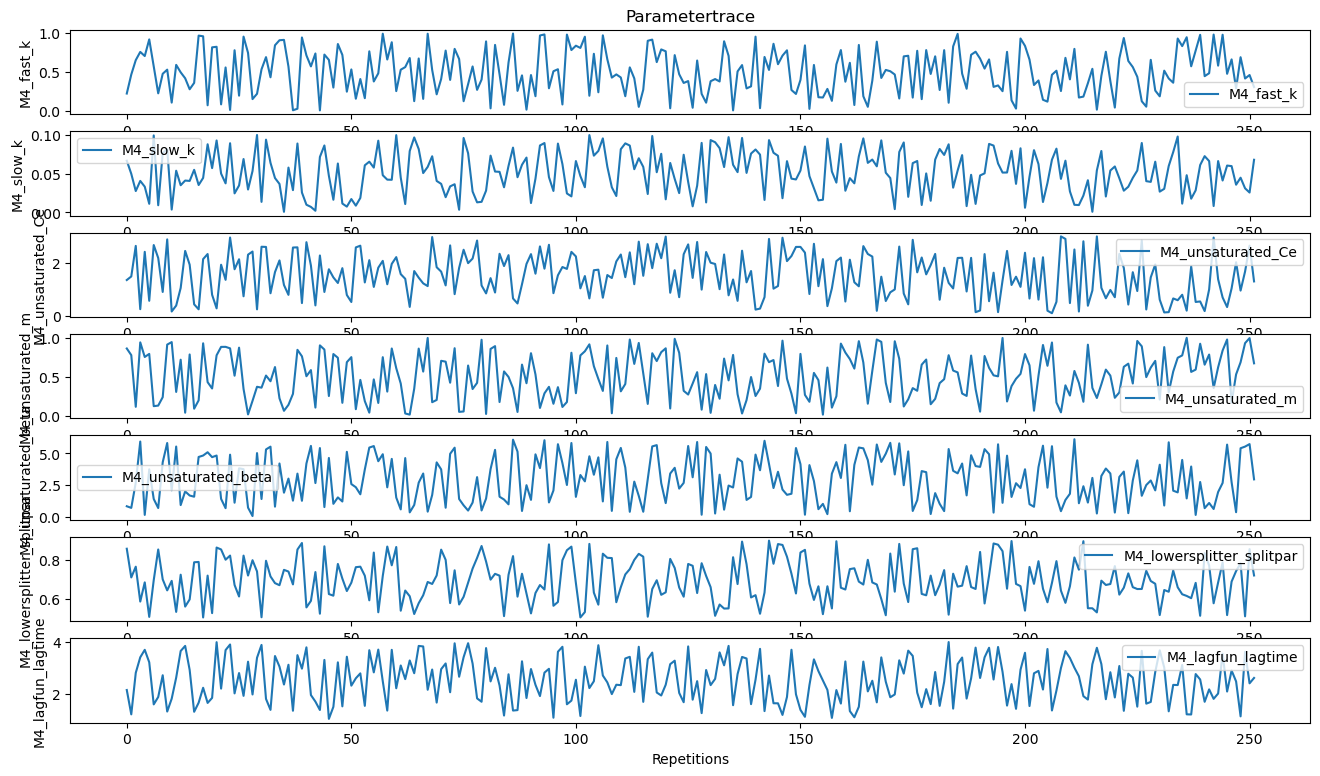

In [1266]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results

In [1267]:
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

Run number 128 has the lowest objectivefunction with: 0.5309


In [1268]:
spotpy.analyser.get_parameters(results)[bestindex]

(0.22048561, 0.08941803, 0.99081784, 0.0824903, 0.2032529, 0.78333724, 1.2465174)

In [1269]:
best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')


best_params_dict

{'M4_fast_k': 0.22048561,
 'M4_slow_k': 0.08941803,
 'M4_unsaturated_Ce': 0.99081784,
 'M4_unsaturated_m': 0.082490295,
 'M4_unsaturated_beta': 0.2032529,
 'M4_lowersplitter_split-par': 0.78333724,
 'M4_lag-fun_lag-time': 1.2465174}

In [1270]:
best_model_run = results[bestindex]                                           # Get the outputs from the best run
best_model_run

(0.5309144, 0.22048561, 0.08941803, 0.99081784, 0.0824903, 0.2032529, 0.78333724, 1.2465174, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.00237849, 0.00219194, 0.00201313, 0.00184899, 0.00169833, 0.00156002, 0.01529965, 0.01437954, 0.01323578, 0.01218522, 0.01122024, 0.01033382, 0.00951953, 0.00877147, 0.00808421, 0.00745279, 0.71061367, 1.3856776, 1.2320282, 0.98633873, 0.85108453, 0.7385524, 0.6484248, 0.5766559, 0.5243086, 0.8239955, 1.4945158, 1.6586897, 1.4028809, 1.1725448, 1.014482, 0.92368686, 0.82641906, 0.746719, 0.7587365, 0.8015843, 0.73443705, 0.6626313, 0.6992733, 0.94393367, 1.4546702, 1.992168, 1.8283966, 1.4959245, 1.7230163, 1.8284587, 1.5853324, 1.3525021, 1.1853638, 1.0550593, 0.94793403, 0.8568029, 0.77752995, 0.70754135, 0.6451227, 0.5890626, 0.53846073, 0.6130517, 0.86867607, 0.84709966, 1.3221412, 1.7068089, 1.4954337, 1.2381431, 1.064808, 0.9364176, 0.8346153, 0.7501903, 0.6780666, 0.6152134, 0.5596903, 0.5101765, 0.47163373

In [1271]:
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [1272]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

-0.12615526187832593

In [1273]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.4690840299148753

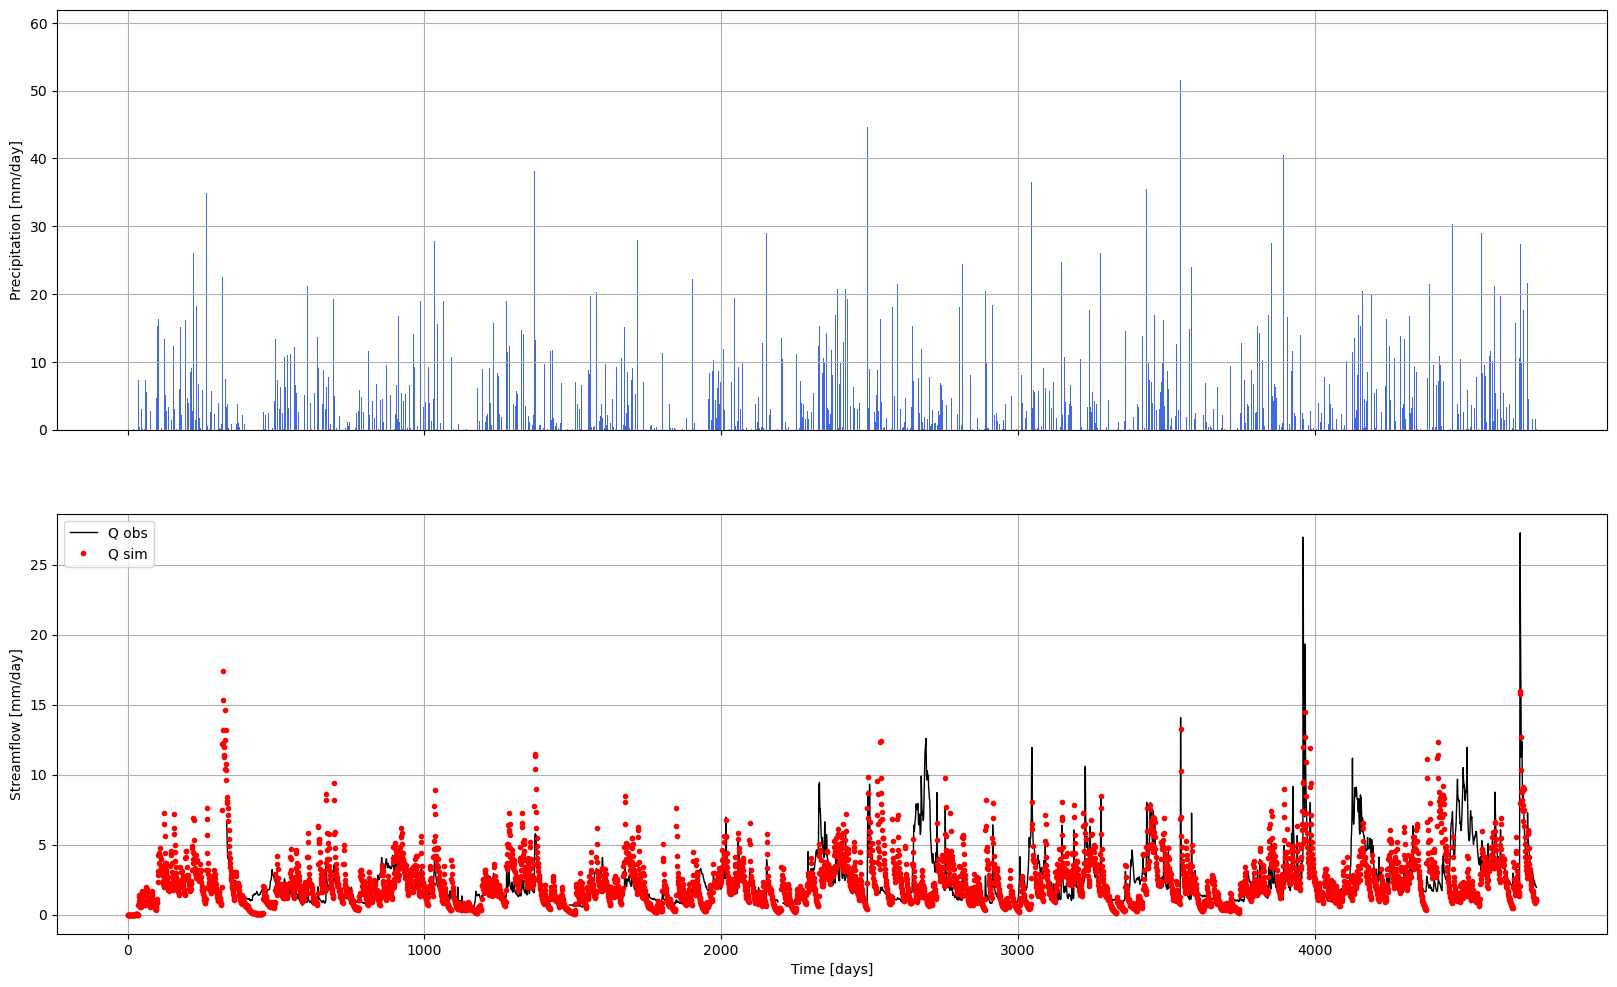

In [1274]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [1275]:
best_params_dict['M4_lowersplitter_split-par'] = 0.66
best_params_dict

{'M4_fast_k': 0.22048561,
 'M4_slow_k': 0.08941803,
 'M4_unsaturated_Ce': 0.99081784,
 'M4_unsaturated_m': 0.082490295,
 'M4_unsaturated_beta': 0.2032529,
 'M4_lowersplitter_split-par': 0.66,
 'M4_lag-fun_lag-time': 1.2465174}

In [1276]:
hyd_mod.reset_states()
hyd_mod.set_input([P,E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

In [1277]:
#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.00057843, 1.1061847 ,
        0.93802522])]

In [1284]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

,Qobs,Qcalc
2002-01-01,NaN,0.000000
2002-01-02,NaN,0.000000
2002-01-03,NaN,0.000000
2002-01-04,NaN,0.000000
2002-01-05,NaN,0.000000
...,...,...
2014-12-27,2.058897,0.946300
2014-12-28,2.104943,1.107769
2014-12-29,2.026007,1.000578
2014-12-30,1.960228,1.106185


In [1283]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1992','12-31-2001', freq='D'))
Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (3653)

In [1285]:
Qtimeseries = Qtimeseries.iloc[365:, :]

In [1286]:
1 - obj_fun_nsee(observations = Qtimeseries.loc[:, "Qobs"], simulation = Qtimeseries.loc[:,"Qcalc"], expo = 0.5)

-0.24098769069959225

<Axes: >

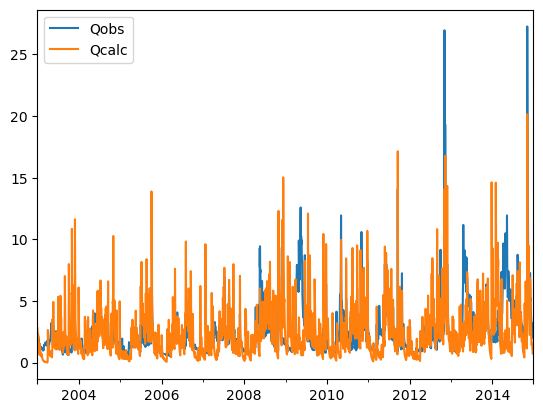

In [1287]:
Qtimeseries.plot()

In [1118]:
Qtimeseries_mon = Qtimeseries.resample('M').agg(lambda x: np.nan if np.isnan(x).any() else np.mean(x))
Qtimeseries_mon

,Qobs,Qcalc
1992-12-31,0.819247,1.502338
1993-01-31,1.651500,2.599670
1993-02-28,1.314997,1.260219
1993-03-31,0.849015,0.510722
1993-04-30,0.784604,0.370410
...,...,...
2001-08-31,0.637060,0.253142
2001-09-30,1.386525,1.580961
2001-10-31,1.145115,1.603398
2001-11-30,1.647341,2.383375


In [1121]:
1 - obj_fun_nsee(observations = Qtimeseries_mon.loc["1995":"2005", "Qobs"], simulation = Qtimeseries_mon.loc["1995":"2005","Qcalc"], expo = 0.5)

0.3004420022635911

<Axes: >

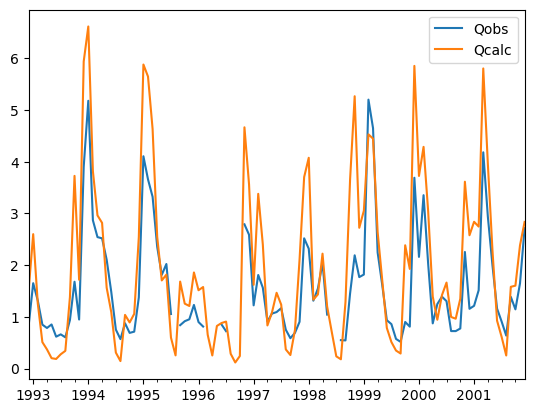

In [1120]:
Qtimeseries_mon.plot()

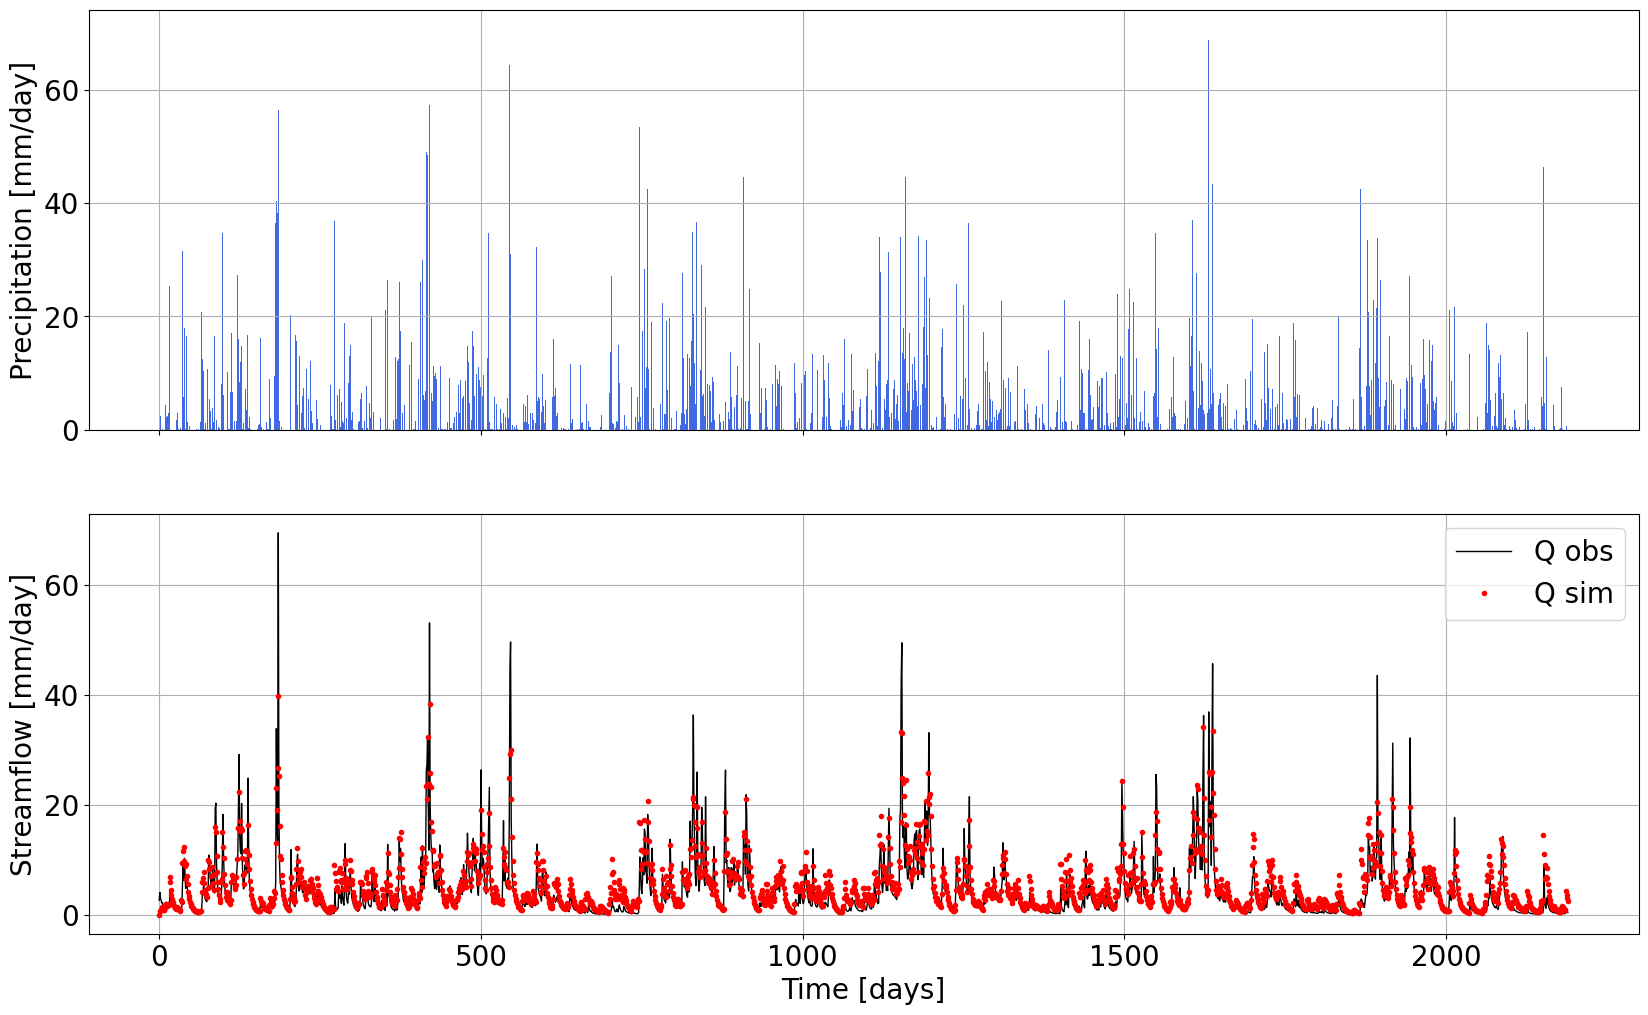

In [22]:
# Plot

fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [45]:
# Python implementation
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit

#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

reservoir_1 = PowerReservoir(parameters={'k': 0.00459953, 'alpha': 2.0, 'Ce': 2.2, 'm': 1.0, 'beta': 4.0},
states={'S0': 0.0},
approximation=num_app,
id='FR1')


hyd_mod = Unit(layers=[[reservoir_1]],
id='model')
hyd_mod

Module: superflexPy
Unit: model
Layers:
	[['FR1']]
********************
Module: superflexPy
Element: FR1
Parameters:
	model_FR1_k : 0.00459953
	model_FR1_alpha : 2.0
	model_FR1_Ce : 2.2
	model_FR1_m : 1.0
	model_FR1_beta : 4.0
States:
	model_FR1_S0 : 0.0


In [171]:
hyd_mod.set_input([P,E])
hyd_mod.set_timestep(1.0)
output = hyd_mod.get_output()
output

[array([nan, nan, nan, ..., nan, nan, nan])]

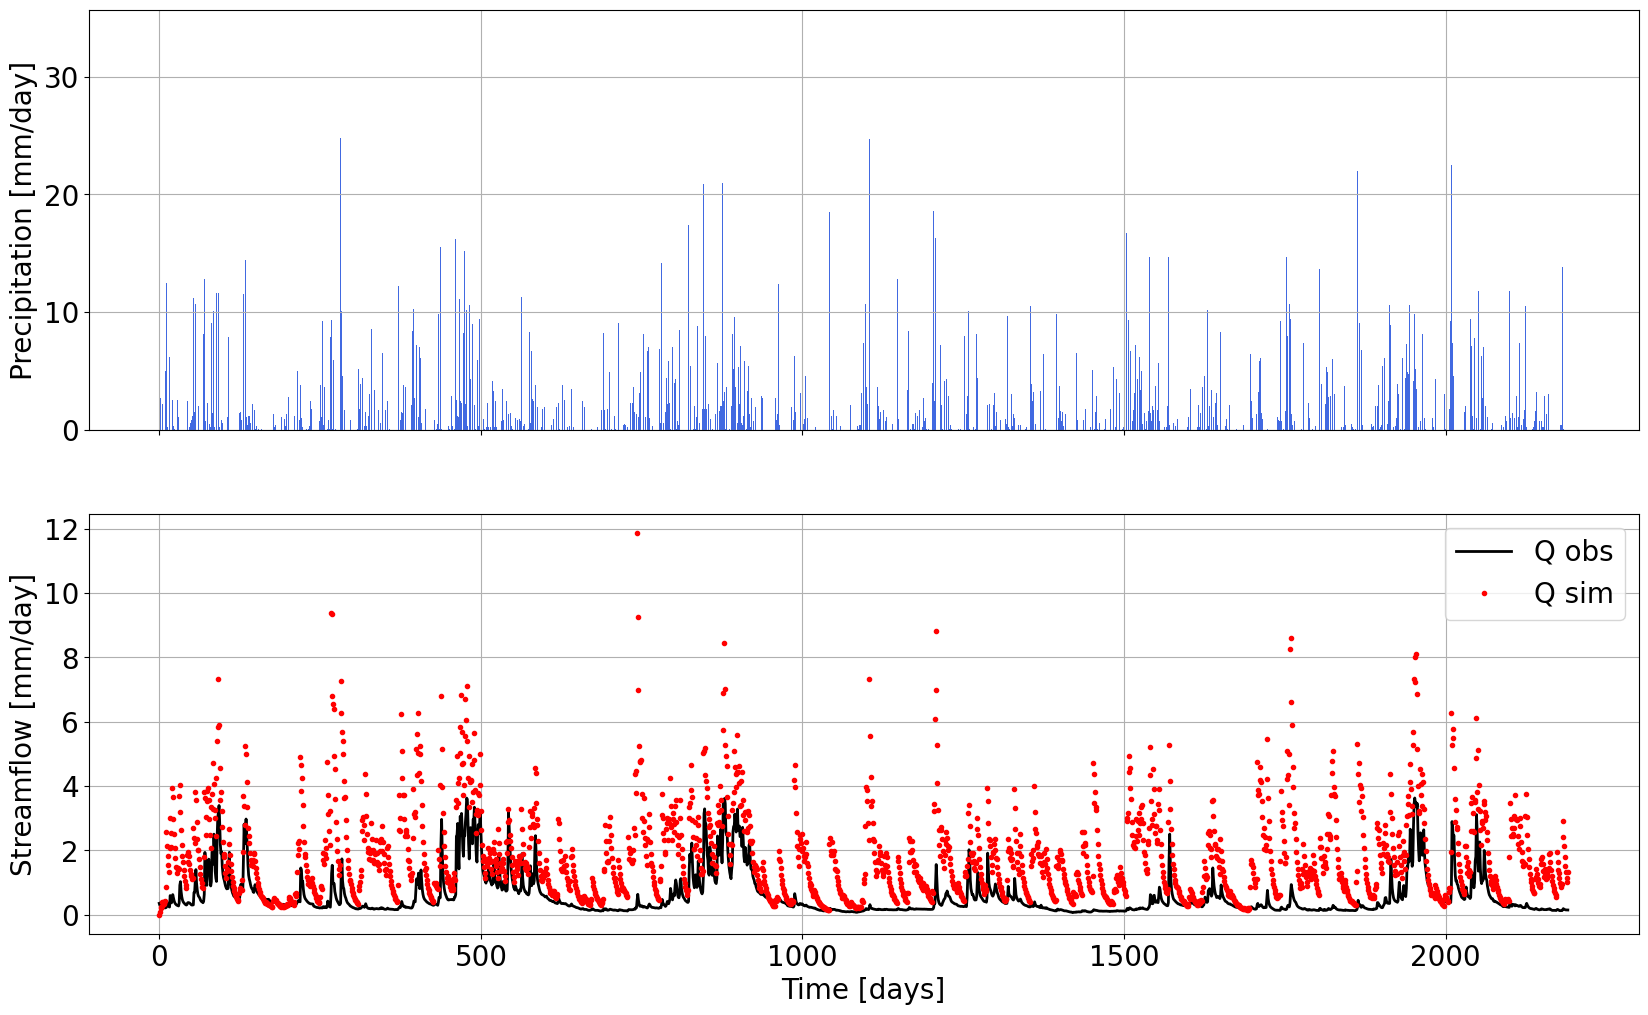

In [47]:
# Plot

fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=2, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), output[0],'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

Analysis:

In [97]:
data

,Index,Year,Month,Day,P,PET,T,Q,Qc
Date,,,,,,,,,
1970-09-01,1,1970,9,1,9.1,1.845658,10.853,0.685241,0
1970-09-02,2,1970,9,2,11.3,1.556095,11.453,1.847172,0
1970-09-03,3,1970,9,3,3.0,1.601786,10.853,1.678345,0
1970-09-04,4,1970,9,4,0.5,1.906808,10.353,1.410207,0
1970-09-05,5,1970,9,5,0.1,1.516710,11.653,1.117241,0
...,...,...,...,...,...,...,...,...,...
2017-08-27,17163,2017,8,27,0.0,2.858037,11.653,1.097379,0
2017-08-28,17164,2017,8,28,0.7,1.947673,12.053,0.958345,0
2017-08-29,17165,2017,8,29,0.0,1.530516,11.353,0.873931,0


In [96]:
data.loc["2002-02-01":"2002-06-01"]

,Index,Year,Month,Day,P,PET,T,Q,Qc
Date,,,,,,,,,
2002-02-01,11477,2002,2,1,33.5,0.566182,5.453,23.089655,0
2002-02-02,11478,2002,2,2,22.0,0.281986,7.253,20.855172,0
2002-02-03,11479,2002,2,3,3.9,0.483363,5.453,14.350345,0
2002-02-04,11480,2002,2,4,16.0,0.572066,4.253,11.569655,0
2002-02-05,11481,2002,2,5,13.9,0.297210,4.853,11.768276,0
...,...,...,...,...,...,...,...,...,...
2002-05-28,11593,2002,5,28,20.0,2.262733,8.053,5.958621,0
2002-05-29,11594,2002,5,29,7.1,2.184199,8.053,7.448276,0
2002-05-30,11595,2002,5,30,1.3,3.040717,8.653,5.362759,0


In [37]:
data_comparation = pd.DataFrame(columns = [["Obs", "Sim"]], 
                                index = pd.date_range('09-01-1997','08-31-2003', freq='D'))
data_comparation["Obs"] = Q_obs
data_comparation["Sim"] = best_simulation
data_comparation

,Obs,Sim
1997-09-01,0.266205,0.000000
1997-09-02,0.221838,0.009412
1997-09-03,0.236849,0.025167
1997-09-04,0.215500,0.011732
1997-09-05,0.186477,0.006310
...,...,...
2003-08-27,0.168463,0.000540
2003-08-28,0.210162,0.157357
2003-08-29,0.301232,0.150761
2003-08-30,0.232179,0.130010


In [39]:
# The same format as the outputs from the model:
observations = data_comparation.loc["2002-02-01":"2002-06-01", "Obs"].values
simulation = data_comparation.loc["2002-02-01":"2002-06-01", "Sim"].values
1 - obj_fun_nsee(observations = observations, simulation = simulation, expo = 0.5)

0.5648110841868053

<Axes: >

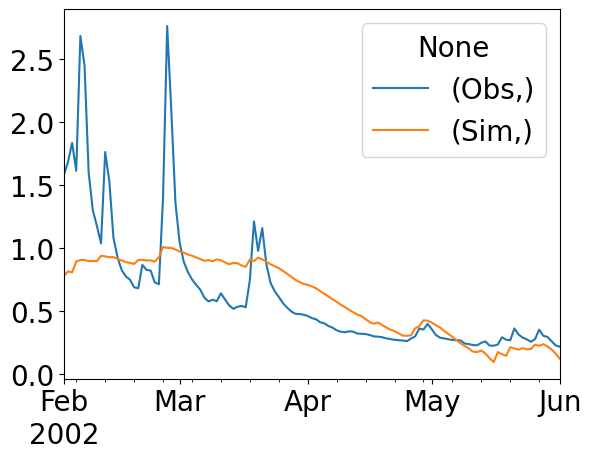

In [40]:
data_comparation.loc["2002-02-01":"2002-06-01"].plot()